In [1]:
function besselsum(p, q, θ)
    ret = besselj(0, p)*besselj(-1, q)*cos(θ)
    i = 1
    nextterm = 1
    while i < 100
        nextterm = besselterm(i, p, q, θ)
        i += 1
        ret += nextterm
    end
    ret
end

function besselterm(n, p, q, θ)
    besselj(n, p)*besselj(-(n+1), q)*cos(n*π/2 + θ) + besselj(-n, p)*besselj(n-1, q)*cos(-n*π/2 + θ) #?
end

besselterm (generic function with 1 method)

In [2]:
using SpecialFunctions
using QuantumOptics

function fidelity(ρ, σ)
    tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2)
end

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function plot_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        # THERE WAS A BUG IN THE LEGNTH(ZEVEN). IT SHOULD BE RIGHT NOW.
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [3]:
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

H_odf (generic function with 1 method)

In [4]:
function H_odf_RWA(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    if length(zernike_coefficients_even) > m
        zernike_coefficients_even = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_even[m + 1]])
    else
        zernike_coefficients_even = []
    end
    if length(zernike_coefficients_odd) > m
        zernike_coefficients_odd = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_odd[m + 1]])
    else
        zernike_coefficients_odd = []
    end
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[length(eventuples)][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[length(oddtuples)][2]
    end
    U * besselsum(p, q, -m * ϕ + ψ)
end     

H_odf_RWA (generic function with 1 method)

In [123]:
Γ = 1/62
ω = 2*π*43.8E3
U = 2*π*10E3
θ = 0.;
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time = 200.0E-6
step_size = evolution_time/100
T = [0.0:step_size:evolution_time;]
zernikeeven = [[0.], [0., .25]];
zernikeodd = [];
order = 1
μ = order * ω

275203.51645446586

In [124]:
ω = 2*π*43.8E3
ρ = 1.
ϕ = π/2
H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
excitationψ = ψ
# Measure in the x basis
excitation = Real.(expect(sigmax(b), ψ));

In [125]:
H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
rwa = Real.(expect(sigmax(b), ψ));
rwaψ = ψ;

In [126]:
ω = 2*π*180E3
μ = order * ω
H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
excitation2ψ = ψ
# Measure in the x basis
excitation2 = Real.(expect(sigmax(b), ψ));

In [127]:
function fidelity(ρ, σ)
    x = real(1 - tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^(1/2))
    if x < 0
        x = 0
    end
    x
end


fidelity (generic function with 1 method)

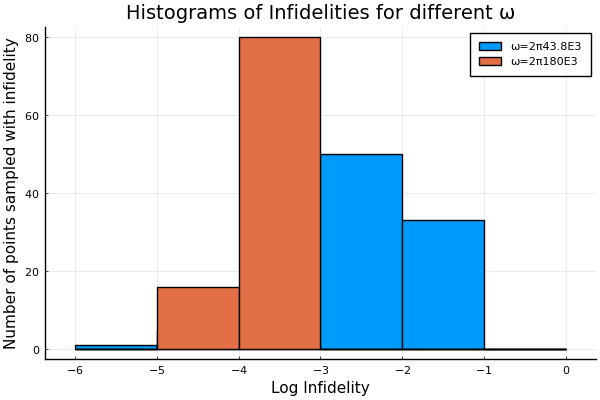

In [128]:
histogram([[log(10, real(fidelity(ψψ.data,rwaψ[i].data)))  for (i, ψψ) in enumerate(excitationψ)],[log(10,real(fidelity(ψψ.data,rwaψ[i].data)))  for (i, ψψ) in enumerate(excitation2ψ)]], bins=-6:0, xlabel="Log Infidelity", labels=["ω=2π43.8E3" "ω=2π180E3"], ylabel="Number of points sampled with infidelity", title="Histograms of Infidelities for different ω")

In [129]:
maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(excitationψ)])

0.012990184234744295

In [130]:
maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(excitation2ψ)])

0.0007643019243998017

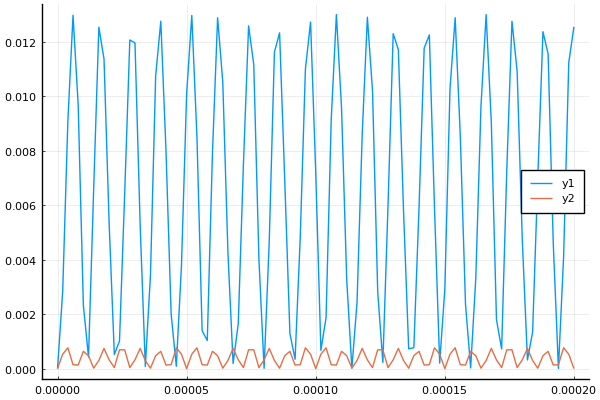

In [131]:
plot(T, [[real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(excitationψ)], [real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(excitation2ψ)]])

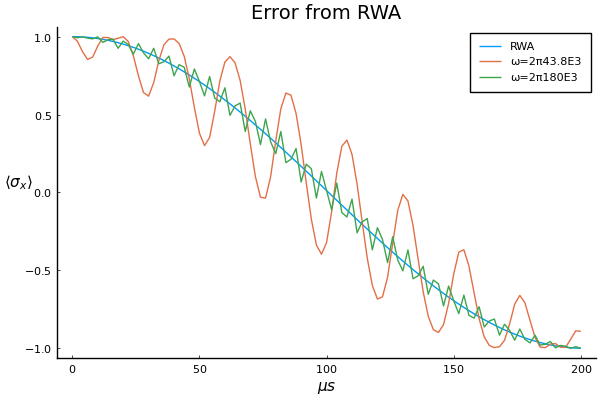

In [132]:
using Plots; pyplot()
using LaTeXStrings
using Statistics
#f=font(13,"cursive")
#using ColorSchemes
plot(T*1E6, [rwa, excitation, excitation2], labels=["RWA" "ω=2π43.8E3" "ω=2π180E3"], grid=false, title="Error from RWA", xlabel=L"\mu s", ylabel=L"\langle \sigma_x\rangle", yguidefontrotation=-90,fontfamily="serif-roman")

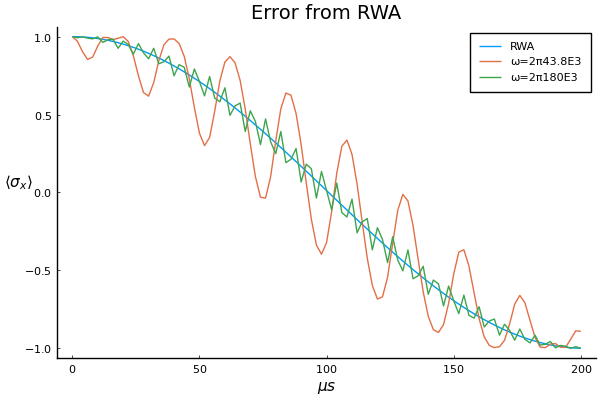

In [133]:
using Plots; pyplot()
using LaTeXStrings
using Statistics
#f=font(13,"cursive")
#using ColorSchemes
plot(T*1E6, [rwa, excitation, excitation2], labels=["RWA" "ω=2π43.8E3" "ω=2π180E3"], grid=false, title="Error from RWA", xlabel=L"\mu s", ylabel=L"\langle \sigma_x\rangle", yguidefontrotation=-90,fontfamily="serif-roman")

    # U versus \omega

In [134]:
results = []
for ω in range(2*π*43.8E3, 2*π*180E3, length=10)
    μ = order * ω
    H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    xψ = ψ
    push!(results, maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(xψ)]))
end

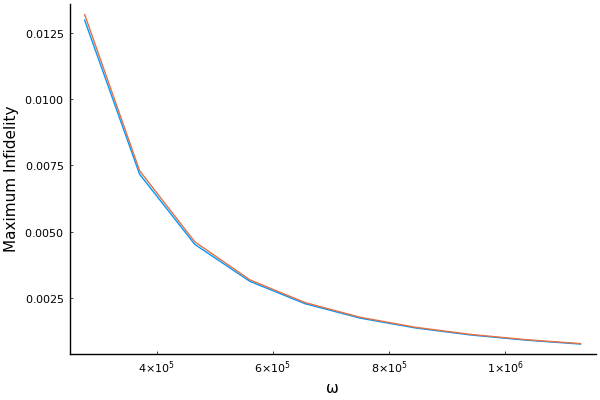

In [152]:
plot(range(2*π*43.8E3, 2*π*180E3, length=10), results, xlabel="ω", ylabel="Maximum Infidelity",grid=false,  legend=false)
plot!(range(2*π*43.8E3, 2*π*180E3, length=10), 1E9 * 1 ./ range(2*π*43.8E3, 2*π*180E3, length=10).^2, xlabel="ω", ylabel="Maximum Infidelity",grid=false,  legend=false)

In [156]:
using LsqFit

# a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
# model(x, p) will accept the full data set as the first argument `x`.
# This means that we need to write our model function so it applies
# the model to the full dataset. We use `@.` to apply the calculations
# across all rows.
@. model(x, p) = p[1] + p[4]*1/x + p[2]*1/x^2 + p[3]*1/x^4 + p[5]*1/x^3

model (generic function with 1 method)

In [158]:
p0 = [0., 0., 0., 0., 0.]
fit = curve_fit(model, range(2*π*43.8E3, 2*π*180E3, length=10), results, p0)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Any,1}}([-0.0038019297615442, 0.5183124317238254, 0.0, 4297.648483939286, 0.0], [-0.0011758582841862944, 0.0006417641251345507, 0.0009122741800449991, 0.000740134928771809, 0.0004692703060381457, 0.0001820707180336719, -9.315485784172498e-5, -0.00034244257243229675, -0.0005677824122376249, -0.0007662761305925227], [1.000000000000063 1.317775247461308e-11 … 3.63367449983243e-6 0.0; 1.000000000000063 7.305058437013772e-12 … 2.7005929257918234e-6 0.0; … ; 0.9999999999999915 9.310368596194025e-13 … 9.653554979224868e-7 0.0; 0.9999999999999915 7.788481421816155e-13 … 8.841941282838924e-7 0.0], true, Any[])

In [159]:
coef(fit)

5-element Array{Float64,1}:
   -0.0038019297615442
    0.5183124317238254
    0.0
 4297.648483939286
    0.0

In [160]:
p0 = [0., 0., 1.]
fit = curve_fit(model, range(2*π*43.8E3, 2*π*180E3, length=10), results, p0)
# fit is a composite type (LsqFitResult), with some interesting values:
#	dof(fit): degrees of freedom
#	coef(fit): best fit parameters
#	fit.resid: residuals = vector of residuals
#	fit.jacobian: estimated Jacobian at solution
lb = [1.1, -0.5]
ub = [1.9, Inf]
p0_bounds = [1.2, 1.2] # we have to start inside the bounds 
# Optional upper and/or lower bounds on the free parameters can be passed as an argument.
# Bounded and unbouded variables can be mixed by setting `-Inf` if no lower bounds
# is to be enforced for that variable and similarly for `+Inf`
fit_bounds = curve_fit(model, xdata, ydata, p0_bounds, lower=lb, upper=ub)

# We can estimate errors on the fit parameters,
# to get standard error of each parameter:
sigma = stderror(fit)
# to get margin of error and confidence interval of each parameter at 5% significance level:
margin_of_error = margin_error(fit, 0.05)
confidence_inter = confidence_interval(fit, 0.05)

# The finite difference method is used above to approximate the Jacobian.
# Alternatively, a function which calculates it exactly can be supplied instead.
function jacobian_model(x,p)
    J = Array{Float64}(undef, length(x), length(p))
    @. J[:,1] = exp(-x*p[2])     #dmodel/dp[1]
    @. @views J[:,2] = -x*p[1]*J[:,1] #dmodel/dp[2], thanks to @views we don't allocate memory for the J[:,1] slice
    J
end
fit = curve_fit(model, jacobian_model, xdata, ydata, p0)

LoadError: BoundsError: attempt to access 3-element Array{Float64,1} at index [4]

In [161]:
results = []
for U in range(2*π*10E1, 2*π*10E4, length=30)   
    evolution_time = 2*π*10E3/U * 200.0E-6
    step_size = evolution_time/100
    T = [0.0:step_size:evolution_time;]
    ω = 2*π*180E3
    μ = order * ω
    H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    xψ = ψ
    H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

    # Measure in the x basis
    rwa = Real.(expect(sigmax(b), ψ));
    rwaψ = ψ;
    push!(results, maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(xψ)]))
end

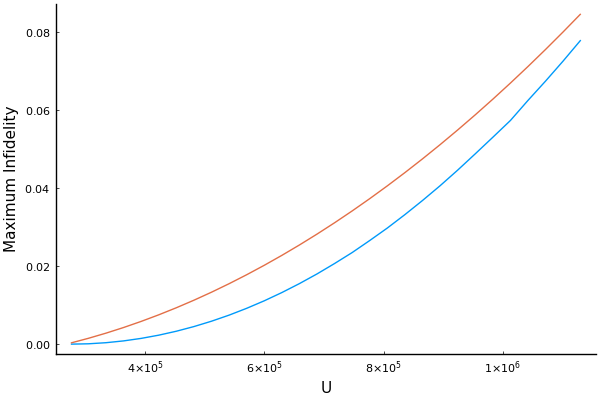

In [196]:
plot(range(2*π*43.8E3, 2*π*180E3, length=30), results, xlabel="U", ylabel="Maximum Infidelity",grid=false,  legend=false)
plot!(range(2*π*43.8E3, 2*π*180E3, length=30), .7E-13*range(2*π*43.8E3, 2*π*180E3, length=30).^2 .-.005)

In [84]:
@. model(x, p) = p[1] + p[2] * x + p[3] * x^2 + p[4] * x^4
p0 = [1., 1., 1., 1.]
fit = curve_fit(model, range(2*π*43.8, 2π*180, length=10)[1:end-1], 10000000*results[1:end-1], p0)

LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([358638.4316781086, -1129.5086417625312, 1.0459541271149289, -2.6431867584345485e-7], [-4406.914249972266, 7214.374304987243, 1916.0247404085676, -3195.684753230562, -3977.415544239, -1193.8384643563732, 2554.223681404139, 3619.6993959856736, -2530.4691109878204], [1.000000000009419 275.2035164575944 75736.9754684872 5.736089453177283e9; 1.000000000009419 370.28905410469036 137113.98358834622 1.880024449552968e10; … ; 1.000000000009419 940.8022799915216 885108.9300389683 7.834178180433412e11; 1.000000000009419 1035.8878176598932 1.0730635707264105e6 1.1514654268548042e12], true, Float64[])

In [85]:
coef(fit)

4-element Array{Float64,1}:
 358638.4316781086
  -1129.5086417625312
      1.0459541271149289
     -2.6431867584345485e-7